In [1]:
# Import Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
import yfinance as yf
import calendar
from datetime import datetime

# Import the API key
from api_keys import alpha_vantage_api_key, bls_api_key, fred_api_key
from fredapi import Fred # https://pypi.org/project/fredapi/  https://cran.r-project.org/web/packages/eFRED/vignettes/FetchingDataFromFRED.html

## CREATING A REQUESTS
Using yf and FREDAPI aquire the monthly Interest Rates and Profits over 10 years (2014-2024)

For this segment, we will make our request to the FRED API and yf API for data in the form of a json and dataframe respectively, please
ensure you have edited the api_keys.py file to have your unique FRED key
###### Most of this section has been done by Bailey

In [2]:
# FRED API url assembly
url = "https://api.stlouisfed.org/fred/series/observations"
params = {
    "series_id": "FEDFUNDS",  # Interest rate series ID
    "api_key": fred_api_key,  # Replace with your API key
    "file_type": "json",
    "observation_start": "2014-01-01", # Starting year of data gathering
    "observation_end": "2023-12-01" # Ending year is December of 2023 due to yf not having data for January of 2024
}
# Make the response, ensure that you've added your API key for FRED in the api_keys.py file else this request will not work
# Please also note that FRED has a limited number of requests per day so only run this cell a few times
response = requests.get(url, params=params)
data = response.json()
final_date = []
final_rate = []

In [3]:
# YF dataframe request, please also refrain from running this cell too often
stock_data = yf.download('QQQ', start='2014-01-01', end='2024-01-01', progress=False).reset_index()

## Assemble the Dataframes ready for merging
In this segment we will take our raw data from our requests and sort it into monthly data ready to be all merged together into a complete frame

In [4]:
## Using yf dataframe to make a new dataframe for Monthly Profits, this cell was done by Jun with slight alterations by Bailey for his use ##
# Date, Month Column creation by using Date
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Month_Number'] = stock_data['Date'].dt.month

# Close price for each Year, Month
monthly_data = stock_data.groupby(['Year', 'Month_Number'])
last_close = monthly_data['Close'].last().reset_index()
first_open = monthly_data["Open"].first().reset_index()
profit_monthly = last_close['Close'] - first_open['Open']
profit_df = pd.DataFrame({'profit_monthly': profit_monthly})

# dataFrame creation
monthly_profit_df = pd.DataFrame({
                                    'Year': last_close['Year'],
                                    'Month_Number': last_close['Month_Number'],
                                    'Monthly_Profit': profit_df['profit_monthly']
                                })

# Generate month numbers (1-12)
month_numbers = list(range(1, 13))

# Use list comprehension to map month numbers to month names
month_names = [calendar.month_name[month] for month in month_numbers]

# Create the DataFrame
month_df = pd.DataFrame({
                            'Month_Number': month_numbers,
                            'Month': month_names
                        })

# Merge the DataFrames on 'Month' from monthly_profit_df and 'Month Number' from month_df
monthly_profit_merge_df = pd.merge(monthly_profit_df, month_df, left_on='Month_Number', right_on='Month_Number', how='left')
monthly_profit_final_df = monthly_profit_merge_df[["Year", "Month", "Monthly_Profit"]]

In [5]:
## FRED API dataframe
datatotal = 0
updated_date = []
updated_rate = [] # assigned variables outside forloop with empty variables ready to be appended
# For loop will take the date and rate from the json file for the 10 years requested and add the values to a new array
for observation in data["observations"]:
    date = observation["date"]
    interest_rate = observation["value"]
    updated_date.append(date)
    updated_rate.append(interest_rate)
    datatotal = datatotal + 1

monthly_interest_df = pd.DataFrame({
    "Date" : updated_date,
    "Interest_Rate" : updated_rate
    })
monthly_interest_df[['Year', 'Month', 'Day']] = monthly_interest_df["Date"].str.split('-', expand=True)
monthly_interest_df["Month"] = monthly_interest_df['Month'].astype(float) # year and month both needed to change to float for the merge
merged_interest_df = pd.merge(monthly_interest_df, month_df, left_on="Month",right_on="Month_Number", how="left")
same_merged_interest_df = merged_interest_df[['Year', "Month_y", "Interest_Rate"]]
same_merged_interest_df["Year"] = same_merged_interest_df["Year"].astype(float)

C:\Users\baile\AppData\Local\Temp\ipykernel_9700\3533296231.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_merged_interest_df["Year"] = same_merged_interest_df["Year"].astype(float)


In [34]:
# Creating a new merged dataframe of the two separate ones
same_month_df = pd.merge(same_merged_interest_df, monthly_profit_final_df, left_on=["Year", "Month_y"], right_on=["Year", "Month"], how="left")
same_month_df = same_month_df[["Year", "Month", "Interest_Rate", "Monthly_Profit"]]

## Creating the scatters
Now that we have all of our data and its neatly organised, we can create a scatterplot for:
1. Monthly profits [one month before interest rate announce] (y-axis) vs interest rate (x-axis) by scatter plot
2. Monthly profits [same month with interest rate announce] (y-axis) vs interest rate (x-axis) by scatter plot 
3. Monthly profits [one month after interest rate announce] (y-axis) vs interest rate (x-axis) by scatter plot 

1. Monthly Profits compared to the interest rates one month after that month

In [19]:
# Shifting the month column down one to be aligned with next months rates (eg the profits of Feb compared with Interest rates of March)
same_month_df[["Month_After", "Interest_After"]] = same_month_df[["Month", 'Interest_Rate']].shift(-1)
monthafter_df = same_month_df[["Year", "Month_After", "Interest_After", "Monthly_Profit"]]
month_after_df = monthafter_df.drop(monthafter_df.index[-1])
month_after_df

,Year,Month_After,Interest_After,Monthly_Profit
0,2014.0,February,0.07,-1.280006
1,2014.0,March,0.08,4.229996
2,2014.0,April,0.09,-1.820000
3,2014.0,May,0.09,-0.709999
4,2014.0,June,0.10,3.779999
...,...,...,...,...
114,2023.0,August,5.33,13.609985
115,2023.0,September,5.33,-4.320007
116,2023.0,October,5.33,-22.130005
117,2023.0,November,5.33,-7.670013


Text(0.5, 1.0, '10 Year comparison of Interest Rates a month after Profits')

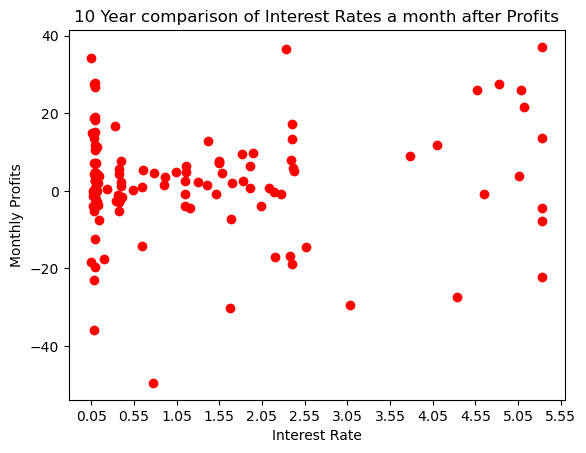

In [26]:
ma_int_rate = month_after_df["Interest_After"].tolist()
ma_month_prof = month_after_df["Monthly_Profit"].tolist()

ma_int_rate_float = [float(val) for val in ma_int_rate]
ma_month_prof_float = [float(val) for val in ma_month_prof]

plt.scatter(ma_int_rate_float, ma_month_prof_float, color='red', label="Dataset1")
plt.xticks(np.arange(min(ma_int_rate_float), max(ma_int_rate_float)+0.5, 0.5))
plt.xlabel('Interest Rate')
plt.ylabel('Monthly Profits')
plt.title('10 Year comparison of Interest Rates a month after Profits')

2. Monthly Profits compared to the interest rates of the current month

Text(0.5, 1.0, '10 Year comparison of Interest Rates to Profits of Federal Funds')

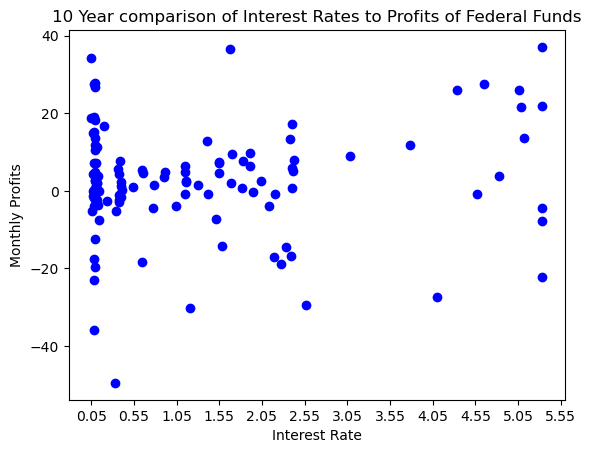

In [25]:
# Scatter for same month
# Changing values to lists and floats to help neaten the xticks and the scatter
int_rate = same_month_df["Interest_Rate"].tolist()
month_prof = same_month_df["Monthly_Profit"].tolist()

int_rate_float = [float(val) for val in int_rate]
month_prof_float = [float(val) for val in month_prof]

plt.scatter(int_rate_float, month_prof_float, color='blue', label="Dataset2")
plt.xticks(np.arange(min(int_rate_float), max(int_rate_float)+0.5, 0.5))
plt.xlabel('Interest Rate')
plt.ylabel('Monthly Profits')
plt.title('10 Year comparison of Interest Rates to Profits of Federal Funds')

3. Monthly Profits compared to the interest rates one month prior to that month

In [37]:
# Shifting the month column up one to be aligned with prior months rates (eg the profits of Feb compared with Interest rates of Jan)
same_month_df[["Month_Before", "Interest_Before"]] = same_month_df[["Month", 'Interest_Rate']].shift(1)
monthbefore_df = same_month_df[["Year", "Month_Before", "Interest_Before", "Monthly_Profit"]]
month_before_df = monthbefore_df.drop(monthbefore_df.index[0])
month_before_df

,Year,Month_Before,Interest_Before,Monthly_Profit
1,2014.0,January,0.07,4.229996
2,2014.0,February,0.07,-1.820000
3,2014.0,March,0.08,-0.709999
4,2014.0,April,0.09,3.779999
5,2014.0,May,0.09,2.490005
...,...,...,...,...
115,2023.0,July,5.12,-4.320007
116,2023.0,August,5.33,-22.130005
117,2023.0,September,5.33,-7.670013
118,2023.0,October,5.33,37.109985


Text(0.5, 1.0, '10 Year comparison of Interest Rates a month after Profits')

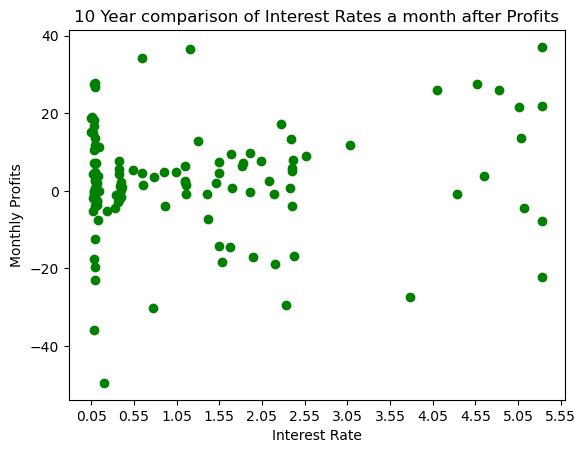

In [39]:
mb_int_rate = month_before_df["Interest_Before"].tolist()
mb_month_prof = month_before_df["Monthly_Profit"].tolist()

mb_int_rate_float = [float(val) for val in mb_int_rate]
mb_month_prof_float = [float(val) for val in mb_month_prof]

plt.scatter(mb_int_rate_float, mb_month_prof_float, color='green', label="Dataset1")
plt.xticks(np.arange(min(mb_int_rate_float), max(mb_int_rate_float)+0.5, 0.5))
plt.xlabel('Interest Rate')
plt.ylabel('Monthly Profits')
plt.title('10 Year comparison of Interest Rates a month after Profits')

All Scatters compared to one another

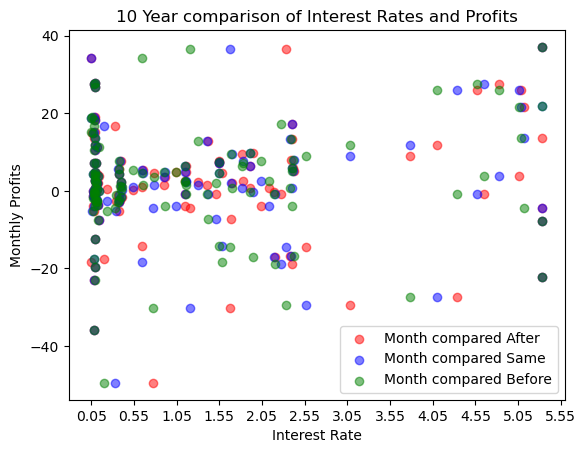

In [42]:
plt.scatter(ma_int_rate_float, ma_month_prof_float, color='red', label="Month compared After", alpha=0.5)
plt.xticks(np.arange(min(ma_int_rate_float), max(ma_int_rate_float)+0.5, 0.5))
plt.scatter(int_rate_float, month_prof_float, color='blue', label="Month compared Same", alpha=0.5)
plt.xticks(np.arange(min(int_rate_float), max(int_rate_float)+0.5, 0.5))
plt.scatter(mb_int_rate_float, mb_month_prof_float, color='green', label="Month compared Before", alpha=0.5)
plt.xticks(np.arange(min(mb_int_rate_float), max(mb_int_rate_float)+0.5, 0.5))

plt.xlabel('Interest Rate')
plt.ylabel('Monthly Profits')
plt.title('10 Year comparison of Interest Rates and Profits')
plt.legend()
plt.show()